In [28]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import h5py
import json
import csv
import os
from bmtool.util import util
from bmtk.simulator import bionet

from analysis import plot # imoporting analysis module enables import from model folder
from build_input import get_populations, get_stim_cycle, t_start, on_time, off_time

TRIAL_NAME = "long_130"
RESULT_PATH = "simulation_results_v4"
if 'short' in TRIAL_NAME:
    RESULT_PATH +="/short"
if 'long' in TRIAL_NAME:
    RESULT_PATH +='/long'
if 'baseline' in TRIAL_NAME:
    RESULT_PATH +='/baseline'
TRIAL_PATH = os.path.join(RESULT_PATH, TRIAL_NAME)
INPUT_PATH = os.path.join('..', 'M1Focus', 'input')

In [29]:
isbaseline = 'baseline' in TRIAL_NAME
if isbaseline:
    config = 'config.json'
elif 'const' in TRIAL_NAME:
    config = 'config_const.json'
else:
    config = 'config_short.json' if 'short' in TRIAL_NAME else 'config_long.json'
    
run_config = 'sonata_config.json'

spike_file = os.path.join('..', 'Analysis', TRIAL_PATH, 'spikes.h5')
config_file = os.path.join('..', 'M1Focus', config)

pop_color = plot.pop_color
pop_names = plot.pop_names

### Spike Raster

In [30]:
result_config_file = 'config_no_STP.json' if 'no_STP' in TRIAL_NAME else run_config
with open(os.path.join('..', 'Analysis', TRIAL_PATH, result_config_file), 'r') as f:
    conf = json.load(f)
    t_stop = conf['run']['tstop'] / 1000

nodes = util.load_nodes_from_config(config_file)
network_name = 'cortex'
cortex_df = nodes[network_name]
test = h5py.File(spike_file)
test['spikes'].keys()


with h5py.File(spike_file) as f:
   spikes_df = pd.DataFrame({
       'node_ids': f['spikes'][network_name]['node_ids'],
       'timestamps': f['spikes'][network_name]['timestamps']
   })
   spikes_df.sort_values(by='timestamps', inplace=True, ignore_index=True)

In [31]:
if isbaseline:
    id_column = 'node_ids'
else:
    id_column = 'sorted_id'
    with open(os.path.join(INPUT_PATH, 'Assembly_ids.csv'), 'r') as f:
        assembly_ids = [np.array(list(map(int, row)), dtype='uint64') for row in csv.reader(f)]
        thal_ids = assembly_ids[:len(assembly_ids) // 2]
        assembly_ids = assembly_ids[len(assembly_ids) // 2:]

    node_ids = cortex_df.index.values
    non_assy_ids = np.array(sorted(set(node_ids).difference(set(np.concatenate(assembly_ids)))))
    assembly_list = assembly_ids + [non_assy_ids,]
    num_5A = node_ids.size // 2
    sorted_assy = [[], []] # 5A and 5B
    for assy in assembly_list:
        idx_5A = assy < num_5A
        sorted_assy[0].append(assy[idx_5A])
        sorted_assy[1].append(assy[~idx_5A])

    sorted_ids = np.zeros_like(node_ids)
    for i, node_id in enumerate(np.concatenate(sorted_assy[0] + sorted_assy[1])):
        sorted_ids[node_id] = i
    cortex_df['sorted_id'] = sorted_ids
    spikes_df['sorted_id'] = cortex_df.loc[spikes_df['node_ids'], 'sorted_id'].values

In [32]:
if not isbaseline:
    t_cycle, n_cycle = get_stim_cycle(on_time, off_time, t_start, t_stop)
    window = t_start + np.array([[0, on_time]])
    windows = (window + t_cycle * np.arange(n_cycle).reshape(n_cycle, 1))
else:
    windows = np.array([[0., t_stop]])

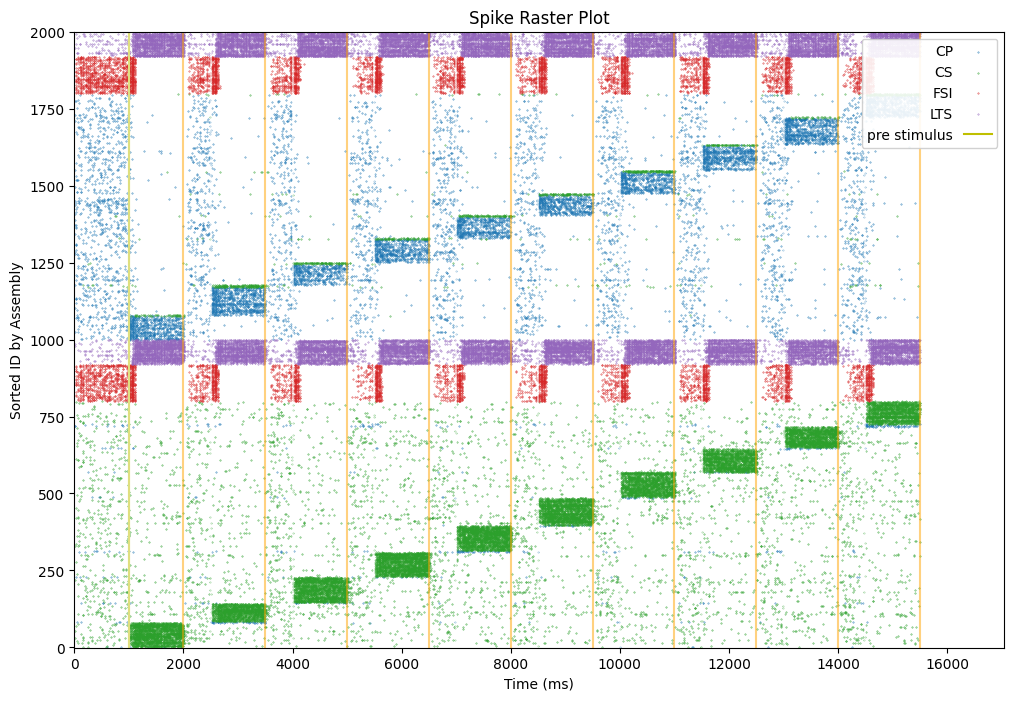

In [33]:
# %matplotlib notebook

spikes_df['pop_name'] = cortex_df.loc[spikes_df['node_ids'], 'pop_name'].values
pop_spike = get_populations(spikes_df, pop_names)

_, ax = plt.subplots(1, 1, figsize=(12, 8))
plot.raster(pop_spike, pop_color, id_column=id_column, ax=ax)
ax.axvline(t_start * 1000, color='y', label='pre stimulus')
if not isbaseline:
    for win in windows:
        ax.axvline(win[0] * 1000, color='white', alpha=0.5)
        ax.axvline(win[1] * 1000, color='orange', alpha=0.5)
    ax.set_ylabel('Sorted ID by Assembly')
ax.legend(loc='upper right', framealpha=0.9, markerfirst=False)
#ax.set_xlim([0, 2000])
ax.set_xlim([0, 1.1 * spikes_df['timestamps'].max()])
ax.set_ylim([cortex_df.index.min() - 1, cortex_df.index.max() + 1])
plt.show()

### Firing Rate

In [34]:
frs = plot.firing_rate(spikes_df, num_cells=len(cortex_df), time_windows=windows)
Cortex_nodes = get_populations(cortex_df, pop_names, only_id=True)
pop_fr = {p: frs[nid] for p, nid in Cortex_nodes.items()}

if not isbaseline:
    print('Stimulus on time: ')

print('Firing rate: mean, std')
for p, fr in pop_fr.items():
    print(f'{p}: {fr.mean():.3g}, {fr.std():.3g}')

Stimulus on time: 
Firing rate: mean, std
CP: 0.936, 0.647
CS: 2.54, 1.28
FSI: 1.92, 0.734
LTS: 17.4, 7.87


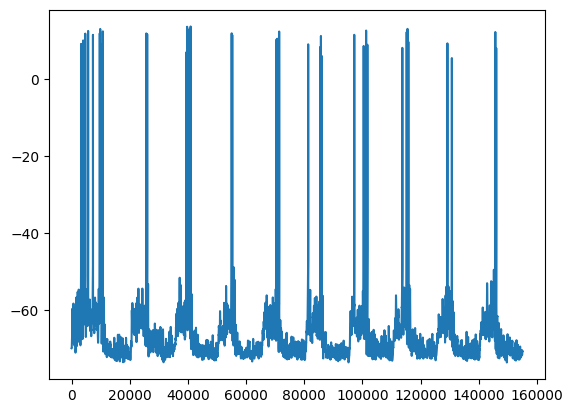

In [35]:
CP_ids = [1,35,1005,1236,1688]
CS_ids = [46,124,581,637,1781]
FSI_ids = [815,880,900,1819,1919]
LTS_ids = [924,986,1940,1972,1996]

node_id = FSI_ids[3] 
V_REPORT_PATH = os.path.join(TRIAL_PATH, "v-report-around90-e4.h5")
from bmtk.utils.reports.compartment import CompartmentReport
v_report = CompartmentReport(V_REPORT_PATH)
voltage = v_report.data(node_id=node_id)
plt.plot(voltage)

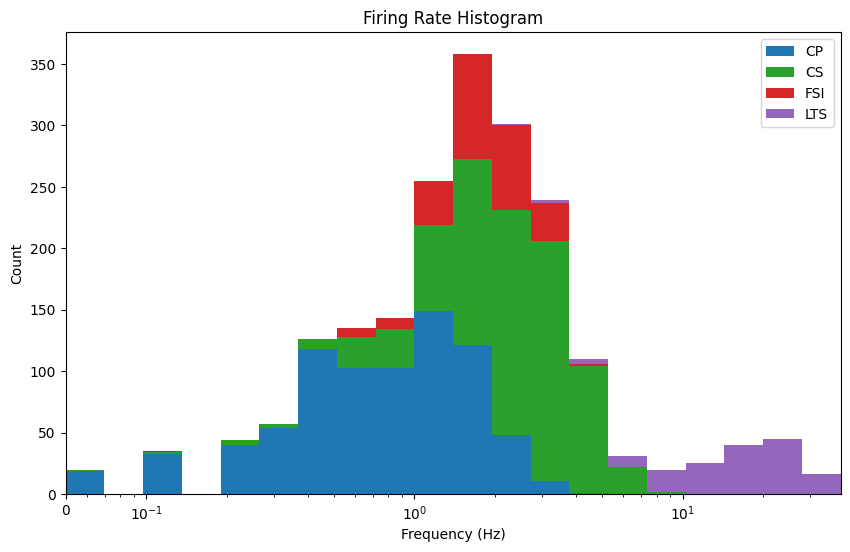

In [36]:
%matplotlib inline

min_fr = 0.5 / plot.total_duration(windows)
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
plot.firing_rate_histogram(pop_fr, pop_color, bins=20, min_fr=min_fr,
                      logscale=True, stacked=True, ax=ax)
plt.show()

### Population spike rate

In [37]:
fs = 2000.
dt = 1000 / fs
time = np.array([0, 1000 * t_stop, dt])
pop_rspk = {p: plot.pop_spike_rate(spk['timestamps'], time) for p, spk in pop_spike.items()}

In [38]:
SAVE_PATH = os.path.join(TRIAL_PATH, 'spike_rate.h5')

with h5py.File(SAVE_PATH, 'w') as f:
    f.create_dataset('time', data=time)
    grp = f.create_group('populations')
    for p, rspk in pop_rspk.items():
        pop = grp.create_group(p)
        pop.create_dataset('data', data=rspk)
        pop.attrs['number'] = len(Cortex_nodes[p])

### Calling plot functions directly

Plotting cortex spike raster


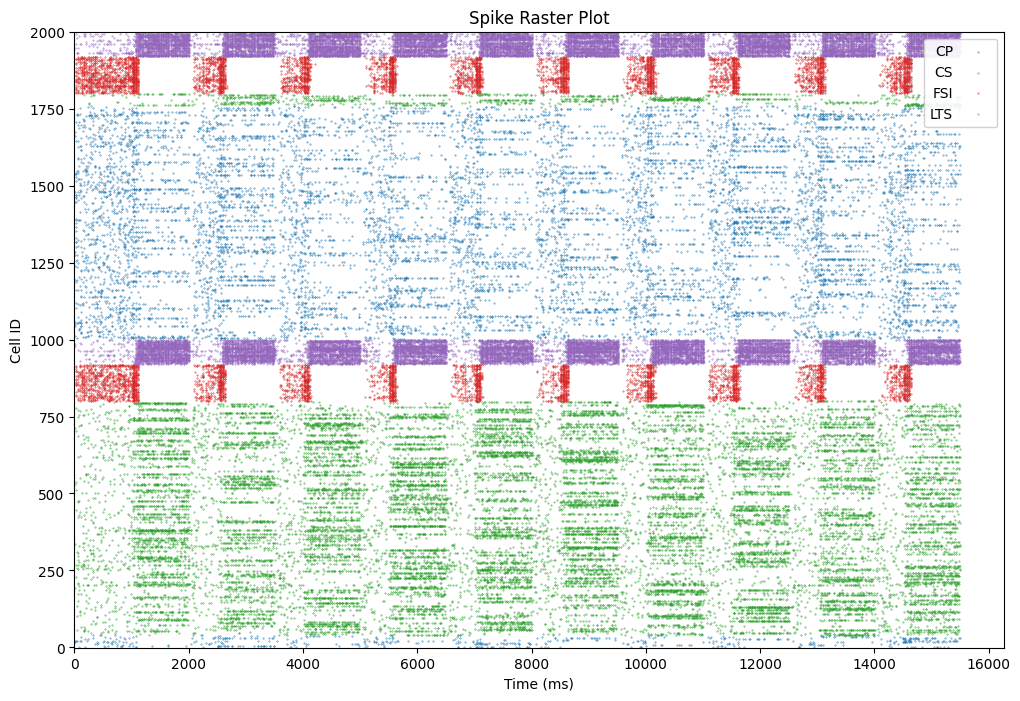

On average: 
Firing rate: mean, std
CP: 0.95, 0.69
CS: 1.89, 1.01
FSI: 2.47, 1.17
LTS: 11.9, 5.7
Plotting firing rates


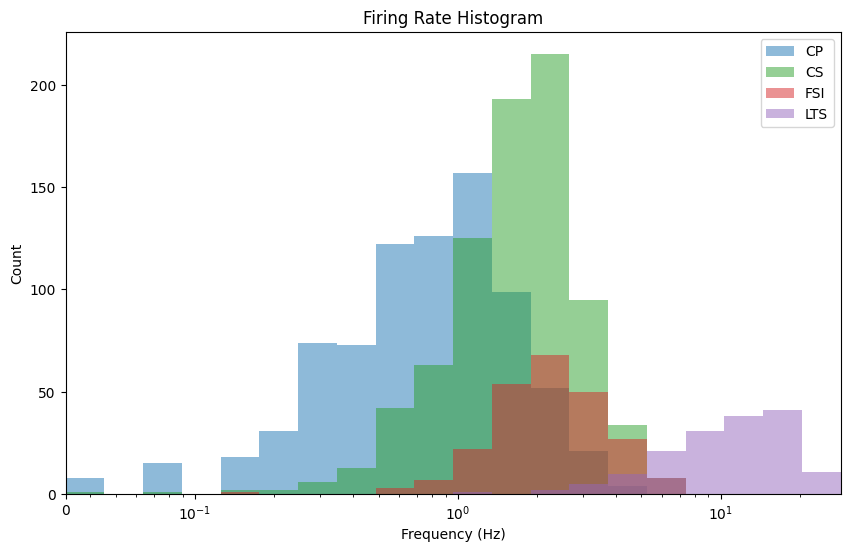

In [39]:
pop_spike = plot.plot(choose=1, spike_file=spike_file, config=config, figsize=(12, 8))

if not isbaseline:
    print('On average: ')
frs = plot.plot(choose=2, spike_file=spike_file, figsize=(10, 6))

In [40]:

# CP ids : 1, 35, 1005, 1236, 1688
# CS ids: 46, 124, 581, 637, 1781
# FSI ids: 815, 880, 900, 1819, 1919
# LTS ids: 924, 986, 1940, 1972, 1996
